# Figure 2: 10x PBMCs datasets

Comparing Symphony mapping vs. de novo integration with Harmony

In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R') # imports
    source('../R/utils.R') # useful functions
})

The three datasets are each sequenced using a different 10x protocol (3'v1, 3'v2, or 5'). The preprocessed expression matrix and metadata were obtained from the Harmony publication (Korsunsky et al, 2019).

In [2]:
my_colors = c("B" = "#66C2A5", 
              "DC" = "#FC8D62",
              "HSC" = "#8DA0CB",
              "MK" = "#E78AC3", 
              "Mono_CD14" = "#A6D854",
              "Mono_CD16" = "#f2ec72",
              "NK" = "#62AAEA", 
              "T_CD4" = "#D1C656",
              "T_CD8" = "#968763",
              "centroid" = "black")

There are cell type labels in the metadata file already, but we will rerun the integration pipeline since the Harmony package may have been updated since then.

## Set up the dataset

In [3]:
# Read in normalized expression and metadata
exprs_norm = readRDS('../data/Fig2_pbmcs/exprs_norm_all.rds')
metadata = read.csv('../data/Fig2_pbmcs/meta_data_subtypes.csv')

dim(exprs_norm)

[1] 33694 20886

In [4]:
metadata = metadata %>% 
  dplyr::rename( pub_res0.8 = res_0.80,
    pub_cell_subtype = cell_subtype,
    pub_cell_type = cell_type ) # 'pub' prefix denotes original Harmony publication

#rename the datasets
metadata$donor = recode(metadata$donor, fivePrime = "5p", threepfresh = "3pv2", threepv1 = "3pv1")
metadata %>% head(4)

,cell_id,donor,nUMI,nGene,percent_mito,pub_cell_type,pub_res0.8,pub_cell_subtype
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>
1,threepfresh_AAACCTGAGCATCATC,3pv2,2394,871,0.03842941,bcells,3,bnaive
2,threepfresh_AAACCTGAGCTAACTC,3pv2,1694,806,0.05726092,mono,5,mono14
3,threepfresh_AAACCTGAGCTAGTGG,3pv2,4520,1316,0.01946903,tcells,2,cd4mem
4,threepfresh_AAACCTGCACATTAGC,3pv2,2788,898,0.01398852,tcells,1,cd4naive


## Run Harmony

Variable gene selection

In [5]:
# Select and subset expression by variable genes
var_genes = vargenes_vst(exprs_norm, groups = as.character(metadata$donor), topn = 1000)
exprs_norm_vargenes = exprs_norm[var_genes, ]
message(paste0('Using ', nrow(exprs_norm_vargenes), ' vargenes'))

Using 2371 vargenes



Scaling and PCA

In [6]:
# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(exprs_norm_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(exprs_norm_vargenes, vargenes_means_sds$mean)
    
## Scale data
exp_scaled = singlecellmethods::scaleDataWithStats(exprs_norm_vargenes, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)
## Run SVD, save gene loadings (s$u)
set.seed(0)
s = irlba(exp_scaled, nv = 20)
Z_pca = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

Harmony integration

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



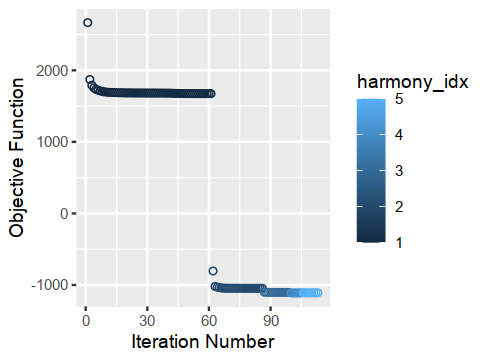

In [7]:
# Run Harmony
set.seed(0)
fig.size(3, 4)
harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca),              ## PCA embedding matrix of cells
        meta_data = metadata,             ## dataframe with cell labels
        theta = c(2),                     ## cluster diversity enforcement
        vars_use = c('donor'),            ## variable to integrate out
        nclust = 100,                     ## number of clusters in Harmony model
        max.iter.harmony = 10,
        return_object = TRUE,             ## return the full Harmony model object
        do_pca = FALSE,                   ## don't recompute PCs
        plot_convergence = TRUE
)

Build Symphony reference

In [8]:
reference = symphony::buildReferenceFromHarmonyObj(
                           harmObj,                # output object from HarmonyMatrix()
                           metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = FALSE)

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



UMAP embedding

In [9]:
set.seed(0)
umap <- uwot::umap(
        t(reference$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .1, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(reference$meta_data, umap$embedding)

# Save UMAP coordinates
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
reference$umap = umap

Save Symphony reference

In [11]:
saveRDS(reference, 'results/pbmcs_10x_init.rds')

## Initial Harmony UMAP

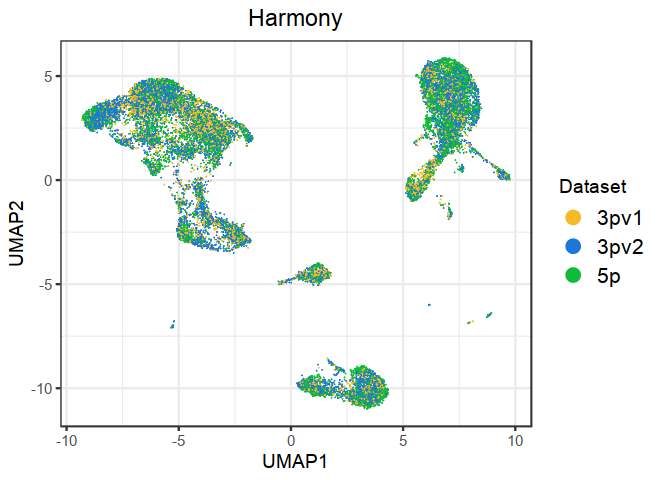

In [12]:
reference_all = readRDS('results/pbmcs_10x_init.rds')

umap_labels = cbind(metadata, reference_all$umap$embedding)

fig.size(4, 5.5)
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = donor)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Harmony', color = 'Dataset') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = c("#f5ba25", "#1c77d9", "#11ba3a")) +
    theme(legend.position = "right") +
    theme(legend.text = element_text(size=12)) + 
    guides(colour = guide_legend(override.aes = list(size = 4)))
p1

## Assign cell types manually

In [13]:
## V := Harmony coordinates (cells by PCs)
## exprs_norm := genes by cells expression matrix (sparse)
## resolutions := vector of cluster resolutions
set.seed(0)

V = t(reference_all$Z_corr)
resolutions = c(0.4, 0.8, 1.0)

snn = singlecellmethods:::buildSNN_fromFeatures(V, prune_snn = 1/25, nn_k = 5, nn_eps = 0.5) %>% 
    as('dgCMatrix') %>% drop0()

clusters_df = Reduce(cbind, lapply(resolutions, function(resolution) {
    Seurat:::RunModularityClustering(snn, resolution = resolution, print.output = FALSE)})) %>% 
    data.frame()
clusters_df = apply(clusters_df, 2, as.character)

markers = apply(clusters_df, 2, function(clusters) {
    presto::wilcoxauc(exprs_norm, clusters)
})

In [19]:
# View lineage markers AUC per cluster
lineage_markers = c('CD3D', # T
                    'IL7R', 'CD4', # CD4+ T
                    'CD8A', # CD8+ T
                    'MS4A1', # B cells
                    'CD14', 'LYZ', # CD14+ Mono
                    'FCER1A', # DCs     
                    'PPBP', # MK
                    'CD34', 'CD59', # HSC
                    'GNLY', 'NKG7', # NK
                    'FCGR3A', 'MS4A7') # CD16+ Mono
m = markers$V2 %>% subset(feature %in% lineage_markers & auc >= 0.7)
m
write.csv(m, 'figures/pbmcs_table_cluster_lineage_markers.csv')

,feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18684,CD3D,0,1.7867683,0.8773333,37656887.5,0.7169888,0.000000e+00,0.000000e+00,88.03010,45.08406636
43330,CD14,1,1.7847784,1.5053078,35867022.5,0.8507316,0.000000e+00,0.000000e+00,80.83039,15.88443776
54913,LYZ,1,4.9239933,3.5906468,39467819.5,0.9361391,0.000000e+00,0.000000e+00,99.95583,47.31500376
76162,IL7R,10,2.0455005,1.2531193,13579714.5,0.7867424,3.136795e-224,3.774685e-221,86.19490,39.38274071
86072,CD3D,10,1.9363519,0.9430115,12662328.5,0.7335935,2.784945e-135,1.617861e-132,89.79118,49.43068318
99255,NKG7,10,2.9888096,2.4120344,15534974.0,0.9000206,0.000000e+00,0.000000e+00,97.44780,23.29204954
103263,FCGR3A,11,1.9437347,1.7555279,14362449.0,0.8863656,0.000000e+00,0.000000e+00,84.88228,9.38293740
105060,GNLY,11,4.2262527,3.9863282,15847917.5,0.9780399,0.000000e+00,0.000000e+00,97.76952,11.86314059
132949,NKG7,11,4.4061561,3.8797388,16012681.5,0.9882082,0.000000e+00,0.000000e+00,100.00000,23.39259923


In [15]:
# View top differentially expressed genes per group
t = top_markers(markers$V2, n=10, auc_min=0, pval_max=1, padj_max=1,
                        pct_in_min=0, pct_out_max=100)
t %>% head()
write.csv(t(t), 'figures/pbmcs_table_top_10_markers.csv')

rank,0,1,10,11,12,13,14,15,16,⋯,20,21,22,3,4,5,6,7,8,9
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,RPL32,S100A8,CCL5,NKG7,HLA-DRB1,S100A8,MT-CYB,CD79B,ITM2C,⋯,S100A8,JCHAIN,PRSS57,LYZ,CD79A,CCL5,CD8B,RPS15A,LST1,MS4A1
2,RPS15A,S100A9,GZMK,PRF1,HLA-DPB1,S100A9,MT-ATP6,CD79A,LILRA4,⋯,CD79A,MZB1,SERPINB1,CTSS,CD74,NKG7,CD8A,RPS27A,COTL1,CD79A
3,RPS14,S100A6,NKG7,GNLY,HLA-DRA,LYZ,MT-CO2,MS4A1,IRF7,⋯,MS4A1,PPIB,HNRNPA1,FCN1,CD79B,IL32,RPL32,RPS12,AIF1,CD74
4,RPS27A,LYZ,GZMA,CST7,HLA-DPA1,S100A12,MALAT1,IGHM,PLD4,⋯,S100A9,SEC11C,RP11-620J15.3,CST3,CD37,CTSW,RPS14,RPL32,FCER1G,CD79B
5,RPS25,TYROBP,KLRB1,CTSW,HLA-DQA1,FCN1,MT-CO3,CD37,IRF8,⋯,CD74,ITM2C,NPM1,TYROBP,TCL1A,B2M,RPS12,LDHB,FCGR3A,BANK1
6,RPS3A,FTL,CTSW,GZMB,CST3,FTL,MT-ND5,IGHD,JCHAIN,⋯,CD79B,TNFRSF17,SOX4,GPX1,MS4A1,HLA-A,RPS3A,RPS14,FTL,CD37


In [16]:
name_clusters = function(clusters, name_list) {
    cluster_labels <- Reduce(rbind, lapply(names(name_list), function(y) {
        data.table(cell_type = y, cluster_ids = name_list[[y]])
    }))
    res <- data.table(cluster_ids = clusters) %>%
        dplyr::left_join(cluster_labels, by = "cluster_ids") %>% 
        dplyr::select(-cluster_ids) %>% 
        with(cell_type)
    return(res)
}

# Manually assign gold standard cell types
name_list = list(
     T_CD4 = c('0', '19', '2', '7'), #CD3D, IL7R
     T_CD8 = c('5', '6', '10'), #CD3D, CD8A
     B = c('15', '4', '9'), # MS4A1, JCHAIN
     Mono_CD14 = c('1', '13', '3', '20'), #CD14, FCGR3A
     Mono_CD16 = c('8'), # FCGR3A, MS4A7
     MK = c('17'), #PPBP
     NK = c('11','18'), #GNLY
     DC = c('12','16'), #FCER1A
     T_dying = c('14'), # mito genes
     HSC = c('21', '22') #CD34, CD59
)

# Add columns to metadata
cluster_ids = clusters_df[,2]
named_clusters = name_clusters(cluster_ids, name_list)
metadata$nnk5_res0.8 = cluster_ids
metadata$cell_type = named_clusters

# Save the final metadata file
saveRDS(metadata, '../data/Fig2_pbmcs/metadata_gold.rds')

# add cell type to reference object
reference_all$meta_data = metadata
saveRDS(reference_all, 'results/pbmcs_10x_init.rds')

# Compare to Harmony publication labels
table(reference_all$meta_data$cell_type, reference_all$meta_data$pub_cell_subtype) 
# good agreement

           
                  adc bmem bnaive cd4mem cd4naive cd8eff cd8mem cd8naive  hsc
  B            1    0 1072   1906      0        0      4      1        0    1
  DC           2  361    0      0      0        0      0      0        0    0
  HSC          1    0    0      0      0        0      0      0        0   62
  MK           0    0    0      0      2        0      0      1        0    0
  Mono_CD14    3   49    3      0      0        5      0      0        1    1
  Mono_CD16    0    0    0      0      0        0      0      0        0    0
  NK           4    0    1      0      1        0     12      1        0    0
  T_CD4       63    0    0      0   2215     3349     30     55      334    0
  T_CD8       84    0    0      1     49       98   1980    398     1110    0
  T_dying    213    0    0      0     19       76      0      0        7    0
           
              mk mono14 mono16   nk  pdc treg
  B            1      0      0    8    0    0
  DC           0      1   

UMAP plot of gold standard cell types

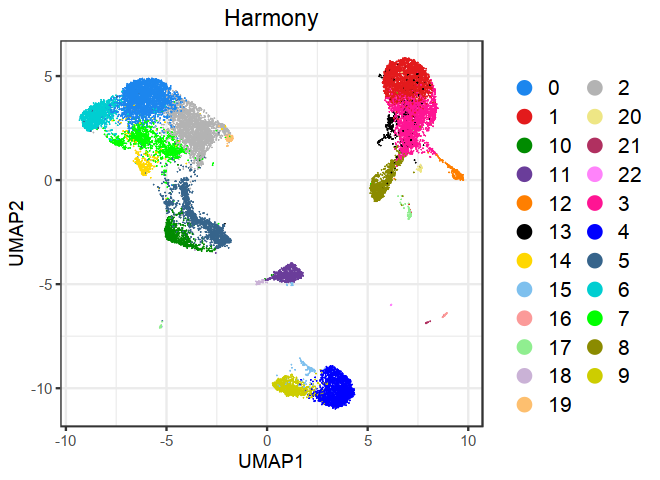

In [17]:
metadata = readRDS('../data/Fig2_pbmcs/metadata_gold.rds')
reference_all = readRDS('results/pbmcs_10x_init.rds')

# Visualize reference clusters
umap_labels = cbind(metadata, reference_all$umap$embedding)

c25 <- c(
  "dodgerblue2", "#E31A1C", # red
  "green4",
  "#6A3D9A", # purple
  "#FF7F00", # orange
  "black", "gold1",
  "skyblue2", "#FB9A99", # lt pink
  "palegreen2",
  "#CAB2D6", # lt purple
  "#FDBF6F", # lt orange
  "gray70", "khaki2",
  "maroon", "orchid1", "deeppink1", "blue1", "steelblue4",
  "darkturquoise", "green1", "yellow4", "yellow3",
  "darkorange4", "brown"
)

# Plot UMAP visualization
fig.size(4, 5.5)
p4 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = nnk5_res0.8)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Harmony', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = c25) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=12)) + 
    guides(colour = guide_legend(override.aes = list(size = 4)))
p4

Adding missing grouping variables: `cell_type`



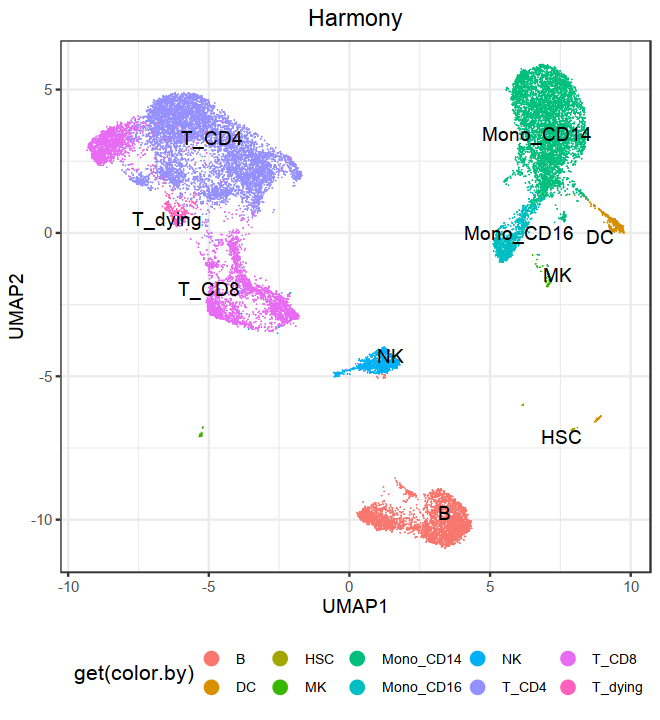

In [18]:
# Visualize reference cell types
fig.size(6, 5.5)
plotReference(reference_all, color.by = 'cell_type', show.centroids = FALSE, 
              as.density = FALSE, title = 'Harmony')

In [20]:
table(reference_all$meta_data$cell_type)


        B        DC       HSC        MK Mono_CD14 Mono_CD16        NK     T_CD4 
     2994       514        64       148      4890       967       916      6316 
    T_CD8   T_dying 
     3762       315 

UMAP plot of gold standard cell types (dying removed)

Remove the low-quality "T_dying" cells (n=315) that are high in mito genes from further analyses.

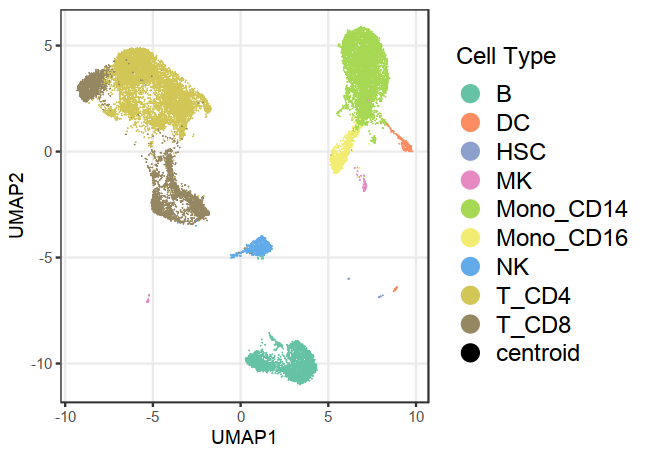

In [21]:
# Visualize reference without dying cells
idx_to_remove = which(reference_all$meta_data$cell_type == 'T_dying')
umap_labels = umap_labels[-idx_to_remove, ]

fig.size(3.8, 5.4) # 4.5 for no legend, 5.4 for legend

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(color = 'Cell Type') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = my_colors) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 5))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
p

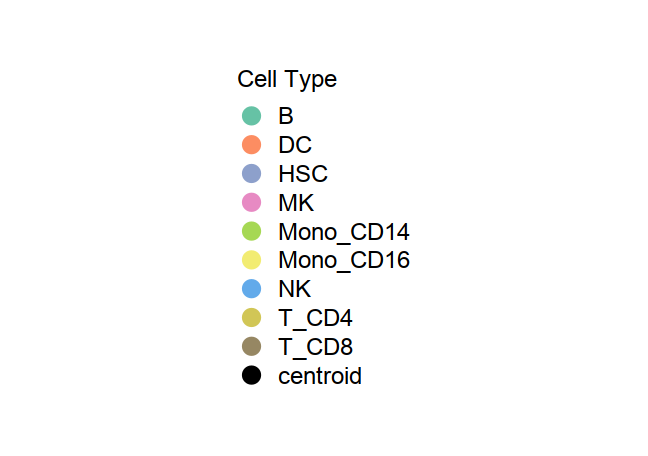

In [22]:
my_legend <- get_legend(p)
as_ggplot(my_legend)
ggsave("figures/pbmcs_Fig_legend_color_by_celltype.pdf", width = 3, height = 5, useDingbats = FALSE)

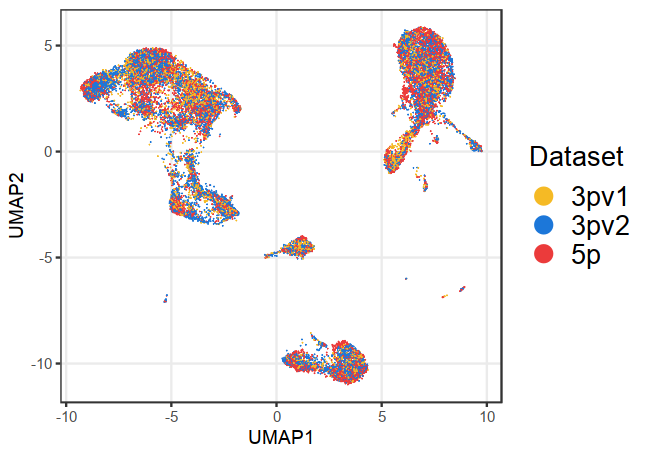

In [23]:
fig.size(3.8, 5.4)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = donor)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(color = 'Dataset') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values=c("#f5ba25", "#1c77d9", "#eb3b3b")) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=16), plot.title = element_text(size=16), 
          legend.title=element_text(size=16)) + 
    guides(colour = guide_legend(override.aes = list(size = 5))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
p

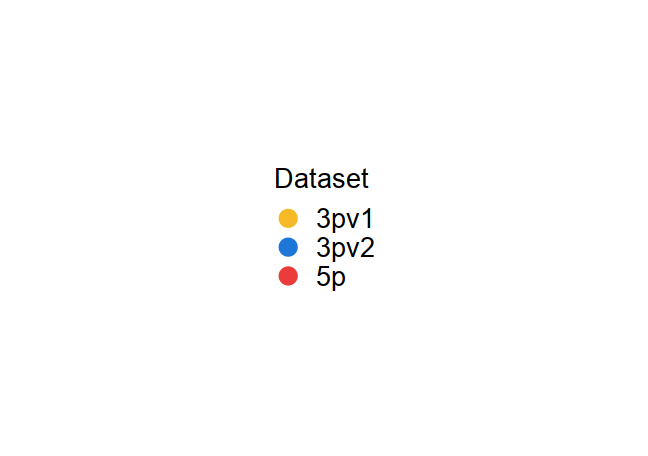

In [24]:
my_legend <- get_legend(p)
as_ggplot(my_legend)
ggsave("figures/pbmcs_Fig_legend_color_by_dataset.pdf", width = 3, height = 5, useDingbats = FALSE)

# Re-run Harmony with low-quality cells removed

In [25]:
# Remove dying cells
idx_to_remove = which(metadata$cell_type == 'T_dying')
metadata = metadata[-idx_to_remove, ]     # remove cell rows from metadata
exprs_norm = exprs_norm[ , -idx_to_remove] # remove cell cols from exprs_norm
dim(exprs_norm)

# Add broad cell type labels
metadata$cell_type_broad <- mapvalues(metadata$cell_type, 
          from=c('Mono_CD14', 'Mono_CD16', 'T_CD4', 'T_CD8'), 
          to=c('Mono', 'Mono', 'T', 'T'))

saveRDS(metadata, '../data/Fig2_pbmcs/metadata_gold_filtered.rds')
saveRDS(exprs_norm, '../data/Fig2_pbmcs/exprs_norm_gold_filtered.rds')

[1] 33694 20571

Variable gene selection

In [26]:
# Select and subset expression by variable genes
var_genes = vargenes_vst(exprs_norm, groups = as.character(metadata$donor), topn = 1000)
exprs_norm_vargenes = exprs_norm[var_genes, ]
message(paste0('Using ', nrow(exprs_norm_vargenes), ' vargenes'))

Using 2357 vargenes



Scaling and PCA

In [27]:
# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(exprs_norm_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(exprs_norm_vargenes, vargenes_means_sds$mean)
    
## Scale data
exp_scaled = singlecellmethods::scaleDataWithStats(exprs_norm_vargenes, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)
## Run SVD, save gene loadings (s$u)
set.seed(0)
s = irlba(exp_scaled, nv = 20)
Z_pca = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

Harmony integration

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



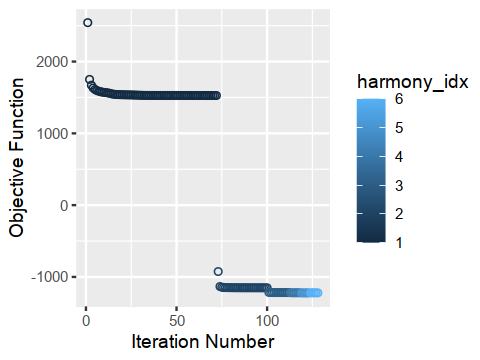

In [28]:
# Run Harmony
set.seed(888)
fig.size(3, 4)
harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca),              ## PCA embedding matrix of cells
        meta_data = metadata,             ## dataframe with cell labels
        theta = c(2),                     ## cluster diversity enforcement
        vars_use = c('donor'),            ## variable to integrate out
        nclust = 100,                     ## number of clusters in Harmony model
        max.iter.harmony = 10,
        return_object = TRUE,             ## return the full Harmony model object
        do_pca = FALSE,                   ## don't recompute PCs
        plot_convergence = TRUE
)

Build Symphony reference

In [29]:
reference = symphony::buildReferenceFromHarmonyObj(
                           harmObj,                # output object from HarmonyMatrix()
                           metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = FALSE)

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



UMAP embedding

In [30]:
set.seed(0)
umap <- uwot::umap(
        t(reference$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .1, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(reference$meta_data, umap$embedding)

# Save UMAP model
save_uwot_path = '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/pbmcs_10x_uwot_model'
model = uwot::save_uwot(umap, file = save_uwot_path, unload = FALSE, verbose = FALSE)
save_uwot_path = '../pre-built_references/pbmcs_10x_uwot_model'
reference$save_uwot_path = save_uwot_path

# Save UMAP coordinates
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
reference$umap = umap

Warning message:
“invalid uid value replaced by that for user 'nobody'”


Save Symphony reference

In [31]:
saveRDS(reference, '../pre-built_references/pbmcs_10x_reference.rds')

### Gold standard UMAP

png 
  2

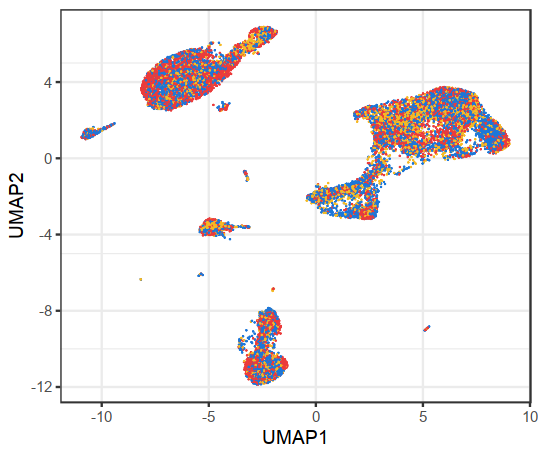

In [32]:
reference_all = readRDS('../pre-built_references/pbmcs_10x_reference.rds')

fig.size(3.8, 4.5)
umap_labels = cbind(metadata, reference_all$umap$embedding)

pdf('figures/gold_standard_colorby_dataset.pdf', height=3.8, width=4.5, useDingbats = FALSE)
p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = donor)) +
    geom_point_rast(size = 0.5, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(color = 'Dataset') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values=c("#f5ba25", "#1c77d9", "#eb3b3b")) +
    theme(legend.position="none") +
    theme(legend.text = element_text(size=16), plot.title = element_text(size=16), 
          legend.title=element_text(size=16)) + 
    guides(colour = guide_legend(override.aes = list(size = 5))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
print(p)
dev.off()
p

png 
  2

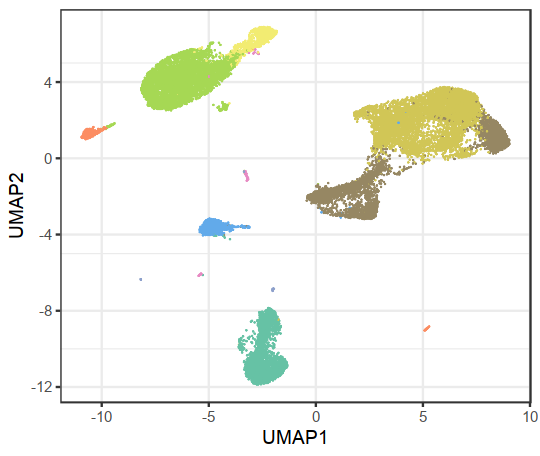

In [33]:
pdf('figures/gold_standard_colorby_celltype.pdf', height=3.8, width=4.5, useDingbats = FALSE)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.5, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(color = 'Cell Type') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = my_colors) +
    theme(legend.position="none") +
    theme(legend.text = element_text(size=16), plot.title = element_text(size=16), 
          legend.title=element_text(size=16)) + 
    guides(colour = guide_legend(override.aes = list(size = 5))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
print(p)
dev.off()
p

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Adding missing grouping variables: `cell_type`



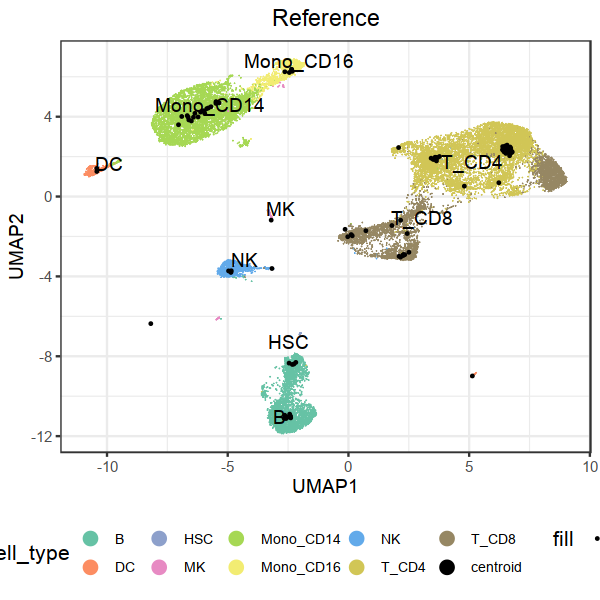

In [34]:
fig.size(5, 5)
plotReference(reference_all, as.density = FALSE, color.by = 'cell_type', 
              show.centroids = TRUE, celltype.colors = my_colors)

# Symphony mapping experiments

## Set up dataset for Symphony comparison

In [35]:
metadata = readRDS('../data/Fig2_pbmcs/metadata_gold_filtered.rds')
exprs_norm = readRDS('../data/Fig2_pbmcs/exprs_norm_gold_filtered.rds')
batches = c("3pv1", "3pv2", "5p")

counts = metadata %>% dplyr::count(donor, cell_type) %>% spread(cell_type, n)
counts

counts$donor = NULL
print(rowSums(counts))

donor,B,DC,HSC,MK,Mono_CD14,Mono_CD16,NK,T_CD4,T_CD8
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3pv1,589,78,21,30,841,352,291,1657,899
3pv2,1231,255,19,63,1822,242,322,2524,1827
5p,1174,181,24,55,2227,373,303,2135,1036


[1] 4758 8305 7508


## Train on 2 batches, test on 1 batch

Treat donor column as batch. I re-ran this code 3 times, one for each batch.

In [40]:
batch = batches[3] # toggle between 1, 2, 3

# Determine which indices to use
idx_ref = which(metadata$donor != batch)
idx_query = which(metadata$donor == batch)

# Subset reference exprs and metadata
exprs_norm_ref = exprs_norm[, idx_ref]
metadata_ref = metadata[idx_ref,]

# Subset query exprs and metadata
exprs_norm_query = exprs_norm[, idx_query]
metadata_query = metadata[idx_query,]

# Build reference
reference = buildReference(
    exprs_norm_ref,
    metadata_ref,
    c('donor'),
    K=100,
    verbose = TRUE,
    do_umap = TRUE,
    do_normalize = FALSE,
    vargenes_method = 'vst',
    vargenes_groups = 'donor',
    topn = 1000,
    save_uwot_path = paste('/data/srlab2/jkang/symphony_reproducibility/pbmcs_10x/results/symphony_umap_', batch, sep = '')
)
saveRDS(reference, paste('results/', batch, '_reference.rds', sep = ''))

Finding variable genes using vst method

Total 1722 genes for downstream steps

Scaling and PCA

Running Harmony integration

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony converged after 12 iterations

Computing reference compression terms

Running UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model



In [41]:
# Map query
query = mapQuery(exprs_norm_query, metadata_query, reference, do_normalize = FALSE)

# Predict query cell types using k-NN
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

res_knn = evaluate(query$meta_data$cell_type, query$meta_data$cell_type_pred_knn)

# Save query and results
saveRDS(query, paste('results/', batch, '_query.rds', sep = ''))
saveRDS(res_knn, paste('results/', batch, '_res_knn.rds', sep = ''))

res_knn

Scaling and synchronizing query gene expression

Found 1722 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



$Conf
           pred_lab
true_lab       B   DC  HSC   MK Mono_CD14 Mono_CD16   NK T_CD4 T_CD8
  B         1174    0    0    0         0         0    0     0     0
  DC           0  177    0    0         4         0    0     0     0
  HSC          2    0   22    0         0         0    0     0     0
  MK           0    0    0   54         1         0    0     0     0
  Mono_CD14    1    1    0    0      2220         2    0     1     2
  Mono_CD16    0    1    0    0        26       346    0     0     0
  NK           1    0    0    0         0         0  299     1     2
  T_CD4        0    0    0    0         0         0    0  2092    43
  T_CD8        0    0    0    0         0         0    0    41   995

$MedF1
[1] 0.9833333

$F1
        B        DC       HSC        MK Mono_CD14 Mono_CD16        NK     T_CD4 
0.9982993 0.9833333 0.9565217 0.9908257 0.9915141 0.9597781 0.9933555 0.9798595 
    T_CD8 
0.9576516 

$Acc
[1] 0.9828183

$PercUnl
[1] 0

$PopSize
        B        DC       H

## Visualization of Symphony results

Ran the code below 3 times, one for each batch.

png 
  2

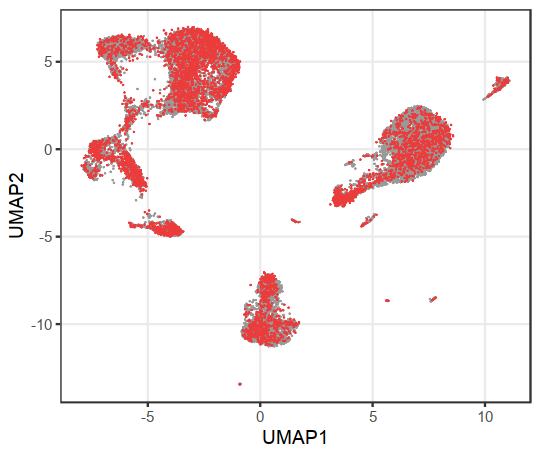

In [46]:
index = 3 #Toggle between 1, 2, 3
batches = c("5p", "3pv2", "3pv1")
colors = c("#f5ba25", "#1c77d9", "#eb3b3b")
batch = batches[index]
col = colors[index]

# Read in results
reference = readRDS(paste('results/', batch, '_reference.rds', sep = ''))
query = readRDS(paste('results/', batch, '_query.rds', sep = ''))

# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'
meta_data_combined = rbind(query$meta_data, reference$meta_data)
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Negate the UMAP values to preserve orientation of visualization.
# This allows the UMAPs to be more easily visually compared (e.g. T cells always on the left)

if (index == 2) umap_combined_labels$UMAP2 = -umap_combined_labels$UMAP2

# Plot query cells on top
umap_combined_labels = umap_combined_labels[order(-as.numeric(factor(umap_combined_labels$ref_query))),]

# Plot UMAP visualization
pdf(paste('figures/', batch, '_umap_colorby_dataset.pdf', sep = ''), height=3.8, width=4.5)
fig.size(3.8, 4.5)

q = umap_combined_labels %>%
    ggplot(aes(x = UMAP1, y = UMAP2, col = ref_query)) +
    geom_point_rast(size = 0.5, stroke = 0.2, shape = 16) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none") +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_color_manual(values=c(col, "#999999")) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))

print(q)
dev.off()
q

png 
  2

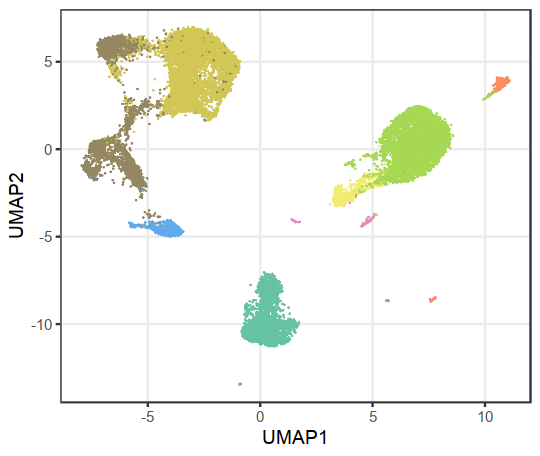

In [47]:
# Plot UMAP visualization
pdf(paste('figures/', batch, '_umap_colorby_celltype.pdf', sep = ''), height=3.8, width=4.5)
fig.size(3.8, 4.5)

#my_colors = c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854",  "#62AAEA", "#D1C656")

q = umap_combined_labels %>%
    #sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.5, stroke = 0.2, shape = 16) +
    theme_bw() +
    #labs(title = paste('Symphony (Query: ', fold, ')', sep=''), color = 'Cell Type') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = my_colors) +
    theme(legend.position="none") +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))

print(q)
dev.off()
q

# Cell type classification results

In [48]:
# Build complete results table
aggregated_f1 = NULL
aggregated_popsize = NULL

for (batch in batches) {
    # Compile Symphony results
    batch_results = readRDS(paste('results/', batch, '_res_knn.rds', sep = ''))
    batch_f1 = batch_results$F1 %>% as.data.frame()
    colnames(batch_f1) = 'F1_score'
    batch_f1$cell_type = rownames(batch_f1)  # Add cell types scores
    rownames(batch_f1) = NULL
    batch_f1$batch = batch # Add name of batch
    batch_f1$method = 'Symphony'
    aggregated_f1 = rbind(aggregated_f1, batch_f1)
    
    # Save confusion matrices as .csv files
    filename = paste0('results/', batch, '_conf_mat.csv')
    write.csv(as.data.frame.matrix(batch_results$Conf), filename)
}

# Calculate accuracy by batch
total_acc = 0
total_pop = 0
for (batch in batches) {
    batch_results = readRDS(paste('results/', batch, '_res_knn.rds', sep = ''))
    batch_accuracy = batch_results$Acc * sum(batch_results$PopSize)
    print(paste(batch, batch_results$Acc, sep = ':'))
    total_acc = total_acc + batch_accuracy
    total_pop = total_pop + sum(batch_results$PopSize)
}
print(total_acc / total_pop)
print(paste("total cells:", total_pop))

[1] "5p:0.982818327117741"
[1] "3pv2:0.973509933774834"
[1] "3pv1:0.96343001261034"
[1] 0.9745759
[1] "total cells: 20571"


png 
  2

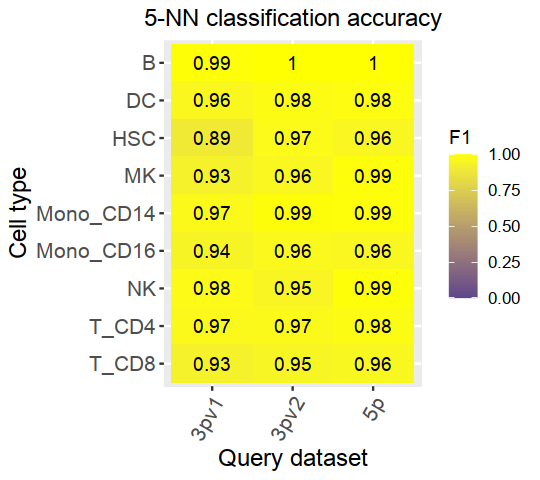

In [49]:
pdf(paste0('figures/symphony_knn_classification.pdf'), height = 4, width = 4.5)
fig.size(4, 4.5)

q = ggplot(aggregated_f1, aes(y = forcats::fct_rev(cell_type), x = batch)) +
    geom_tile(aes(fill = F1_score)) + 
    geom_text(aes(label = round(F1_score, 2))) +
    scale_fill_gradient(low = "mediumpurple4", high = "yellow", limits = c(0, 1)) + 
    theme(legend.position = "right") +
    theme(legend.text = element_text(size=10)) + 
    labs(fill='F1') +
    ylab('Cell type') + xlab('Query dataset') + ggtitle('5-NN classification accuracy') +
    theme(axis.text.x = element_text(angle = 60, hjust = 1, size=12),
        axis.text.y = element_text(hjust = 1, size=12),
        strip.text.y = element_text(size=12),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=14))

print(q)
dev.off()
q

# LISI results

In [50]:
#install.packages("devtools")
#devtools::install_github("immunogenomics/lisi")
library(lisi)

## Compute LISI for gold standard

In [51]:
reference_all = readRDS('../pre-built_references/pbmcs_10x_reference.rds')
harmony_lisi = compute_lisi(t(reference_all$Z_corr), reference_all$meta_data, c('donor', 'cell_type'))

# Separate gold standard LISI scores by query fold
harmony_3pv1_lisi = harmony_lisi[which(reference_all$meta_data$donor == "3pv1"), ]
harmony_3pv1_lisi$experiment = "Gold Standard (3pv1)"

harmony_3pv2_lisi = harmony_lisi[which(reference_all$meta_data$donor == "3pv2"), ]
harmony_3pv2_lisi$experiment = "Gold Standard (3pv2)"

harmony_5p_lisi = harmony_lisi[which(reference_all$meta_data$donor == "5p"), ]
harmony_5p_lisi$experiment = "Gold Standard (5p)"

## Compute LISI for Symphony

In [52]:
## Compute LISI for 3pv1 query Symphony embedding
reference = readRDS('results/3pv1_reference.rds')
query = readRDS('results/3pv1_query.rds')

# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
metadata_combined = rbind(query$meta_data, reference$meta_data)
embedding_combined = cbind(query$Z, reference$Z_corr)

symphony_3pv1_lisi = compute_lisi(t(embedding_combined), metadata_combined, c('donor', 'cell_type'))

# Separate out query cell Symphony LISI scores
symphony_3pv1_lisi = symphony_3pv1_lisi[which(metadata_combined$donor == '3pv1'), ]
symphony_3pv1_lisi$experiment = "Symphony (3pv1)"

In [53]:
## Compute LISI for 3pv2 query Symphony embedding
reference = readRDS('results/3pv2_reference.rds')
query = readRDS('results/3pv2_query.rds')

# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
metadata_combined = rbind(query$meta_data, reference$meta_data)
embedding_combined = cbind(query$Z, reference$Z_corr)

symphony_3pv2_lisi = compute_lisi(t(embedding_combined), metadata_combined, c('donor', 'cell_type'))

# Separate out query cell Symphony LISI scores
symphony_3pv2_lisi = symphony_3pv2_lisi[which(metadata_combined$donor == '3pv2'), ]
symphony_3pv2_lisi$experiment = "Symphony (3pv2)"

In [54]:
## Compute LISI for 5p query Symphony embedding
reference = readRDS('results/5p_reference.rds')
query = readRDS('results/5p_query.rds')

# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
metadata_combined = rbind(query$meta_data, reference$meta_data)
embedding_combined = cbind(query$Z, reference$Z_corr)

symphony_5p_lisi = compute_lisi(t(embedding_combined), metadata_combined, c('donor', 'cell_type'))

# Separate out query cell Symphony LISI scores
symphony_5p_lisi = symphony_5p_lisi[which(metadata_combined$donor == '5p'), ]
symphony_5p_lisi$experiment = "Symphony (5p)"

## Compute LISI for PCA on all cells

In [58]:
reference_all = readRDS('../pre-built_references/pbmcs_10x_reference.rds')
pca_lisi = compute_lisi(t(reference_all$Z_orig), reference_all$meta_data, c('donor', 'cell_type'))

# Separate gold standard LISI scores by query fold
pca_3pv1_lisi = pca_lisi[which(reference_all$meta_data$donor == "3pv1"), ]
pca_3pv2_lisi = pca_lisi[which(reference_all$meta_data$donor == "3pv2"), ]
pca_5p_lisi = pca_lisi[which(reference_all$meta_data$donor == "5p"), ]

pca_3pv1_lisi$experiment = "PCA (3pv1)"
pca_3pv2_lisi$experiment = "PCA (3pv2)"
pca_5p_lisi$experiment = "PCA (5p)"

## Compare LISI scores

In [59]:
lisi_results = rbind(harmony_5p_lisi,  harmony_3pv2_lisi, harmony_3pv1_lisi, 
                     symphony_5p_lisi, symphony_3pv2_lisi, symphony_3pv1_lisi,
                     pca_5p_lisi, pca_3pv2_lisi, pca_3pv1_lisi)

saveRDS(lisi_results, 'results/lisi_results.rds')

In [60]:
lisi_results = readRDS('results/lisi_results.rds')
lisi_results$experiment = as.factor(lisi_results$experiment)
levels(lisi_results$experiment)

[1] "Gold Standard (3pv1)" "Gold Standard (3pv2)" "Gold Standard (5p)"  
[4] "PCA (3pv1)"           "PCA (3pv2)"           "PCA (5p)"            
[7] "Symphony (3pv1)"      "Symphony (3pv2)"      "Symphony (5p)"

In [61]:
lisi_results$experiment = lisi_results$experiment %>%
                        relevel("PCA (5p)") %>% relevel("PCA (3pv2)") %>% relevel("PCA (3pv1)")
## changes the order of plotting

png 
  2

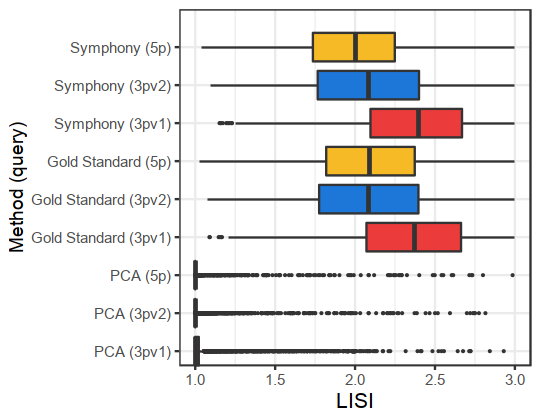

In [62]:
pdf(paste('figures/lisi_benchmark.pdf', sep = ''), height=3.5, width=4.5)

fig.size(3.5, 4.5)
p = ggplot(lisi_results, aes(x = donor, y = experiment, fill = experiment)) +
    geom_boxplot(outlier.size = 0.1, size = 0.5) + 
    scale_fill_manual(values = rep(c("#eb3b3b", "#1c77d9", "#f5ba25"), 4)) +
    xlab('LISI') + ylab('Method (query)') +
    theme_bw() + theme(legend.position = 'none') +
    scale_y_discrete(expand = expansion(add = c(0.2, 1))) +
    theme(axis.title.x = element_text(size = 12))
print(p)
dev.off()
p

## Print LISI stats

Symphony

In [63]:
# 95% CI, alpha = .05 
lisi_results = readRDS('results/lisi_results.rds')
idx = which(lisi_results$experiment %in% c("Symphony (3pv2)", "Symphony (3pv1)","Symphony (5p)"))
lisi_results = lisi_results[idx, ]

n = nrow(lisi_results)
n
me = qt(.975, n - 1)* sd(lisi_results$donor)/sqrt(n)

mean(lisi_results$donor)
mean(lisi_results$donor) - me
mean(lisi_results$donor) + me

[1] 20571

[1] 2.124872

[1] 2.118929

[1] 2.130815

Harmony gold standard

In [64]:
# 95% CI, alpha = .05
lisi_results = readRDS('results/lisi_results.rds')
idx = which(lisi_results$experiment %in% c("Gold Standard (3pv2)", "Gold Standard (3pv1)","Gold Standard (5p)"))
lisi_results = lisi_results[idx, ]

n = nrow(lisi_results)
n
me <- qt(.975, n - 1)* sd(lisi_results$donor)/sqrt(n)

mean(lisi_results$donor)
mean(lisi_results$donor) - me
mean(lisi_results$donor) + me

[1] 20571

[1] 2.149617

[1] 2.143639

[1] 2.155596

In [65]:
# 95% CI, alpha = .05
lisi_results = readRDS('results/lisi_results.rds')
idx = which(lisi_results$experiment %in% c("PCA (3pv2)", "PCA (3pv1)","PCA (5p)"))
lisi_results = lisi_results[idx, ]

n = nrow(lisi_results)
n
me <- qt(.975, n - 1)* sd(lisi_results$donor)/sqrt(n)

mean(lisi_results$donor)
mean(lisi_results$donor) - me
mean(lisi_results$donor) + me

[1] 20571

[1] 1.029167

[1] 1.027305

[1] 1.03103

# Nearest neighbor correlation
In this analysis, we aim to show that the Symphony embedding closely approximates the Harmony gold standard integration when it comes to local neighborhoods for each cell. We will show that the distances to each cell's n nearest neighbors are strongly correlated in the two embeddings, and stronger than a more naive approach, such as projection into PC space.

## Plot k-NN-corr for one cell as an example

Symphony vs. Harmony embeddings

In [67]:
k = 500
batch = '5p'
gold = readRDS('../pre-built_references/pbmcs_10x_reference.rds')
colnames(gold$Z_corr) = gold$meta_data$cell_id

reference = readRDS(paste0("results/", batch, "_reference.rds"))
query = readRDS(paste0("results/", batch, "_query.rds"))
colnames(reference$Z_corr) = reference$meta_data$cell_id
colnames(query$Z) = query$meta_data$cell_id

# Subset gold embedding by reference and query of interest
idx_gold_query = which(gold$meta_data$donor == batch)
gold_ref = gold$Z_corr[, -idx_gold_query]
gold_query = gold$Z_corr[, idx_gold_query]
alt_ref = reference$Z_corr
alt_query = query$Z

# Ensure that ordering of cells matches between gold and alt embeddings
gold_ref = gold_ref[ , colnames(alt_ref)]
gold_query = gold_query[, colnames(alt_query)]

# Calculate the query cells' k nearest reference neighbors in the gold standard embedding
nn_in_gold = nn2(t(gold_ref), t(gold_query), k = k)

corrs = numeric(ncol(gold_query)) # initialize results
i = 1 # example for first cell
neighbors_idx = nn_in_gold$nn.idx[i, ]
    
# Get position of anchor cell in gold embedding
query_anchor_gold = gold_query[, i] %>% # duplicate k times
    matrix(nrow = nrow(gold_query), ncol = k, byrow = FALSE)
    
# Get position of anchor cell in alternate embedding
query_anchor_alt = alt_query[, i] %>% # duplicate k times
    matrix(nrow = nrow(gold_query), ncol = k, byrow = FALSE)
    
# Get positions for its nearest neighbors in the gold embedding
query_neighbors_gold = gold_ref[, neighbors_idx]
    
# Get positions for its nearest neighbors in the alt embedding
query_neighbors_alt = alt_ref[, neighbors_idx]
    
# Calculate distance between anchor cell and each neighbor in gold embedding
distances_gold = sqrt(colSums((query_anchor_gold - query_neighbors_gold)**2))
    
# Calculate distance between anchor cell and each neighbor in alt embedding
distances_alt = sqrt(colSums((query_anchor_alt - query_neighbors_alt)**2))
    
# Calculate Spearman correlation between the two distance vectors
cor(distances_gold, distances_alt, method = 'spearman')

data_1_cell = cbind(distances_gold, distances_alt) %>% as.data.frame()

[1] 0.7238142

png 
  2

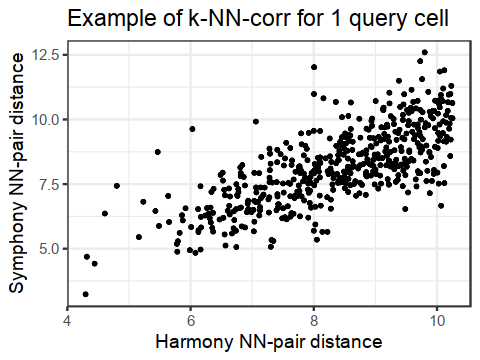

In [68]:
pdf(paste('figures/kNN-corr-1cell-symphony.pdf', sep = ''), height=3, width=4)
fig.size(3,4)
p = ggplot(data_1_cell, aes(x = distances_gold , y = distances_alt)) +
  geom_point_rast(size = 0.8) +
  theme_bw() + 
  xlab('Harmony NN-pair distance') + 
  ylab('Symphony NN-pair distance') + 
  ggtitle('Example of k-NN-corr for 1 query cell')
print(p)
dev.off()
p

PCA_proj vs. Harmony embeddings

In [69]:
# Calculate the query cells' k nearest reference neighbors in the gold standard embedding
k = 500
batch = '5p'

reference = readRDS(paste0("results/", batch, "_reference.rds"))
query = readRDS(paste0("results/", batch, "_query.rds"))
colnames(reference$Z_corr) = reference$meta_data$cell_id
colnames(query$Z) = query$meta_data$cell_id

# Subset gold embedding by reference and query of interest
idx_gold_query = which(gold$meta_data$donor == batch)
gold_ref = gold$Z_corr[, -idx_gold_query]
gold_query = gold$Z_corr[, idx_gold_query]
alt_ref = reference$Z_corr
alt_query = query$Zq_pca # this line different from above
colnames(alt_query) = colnames(query$Z)

# Ensure that ordering of cells matches between gold and alt embeddings
gold_ref = gold_ref[ , colnames(alt_ref)]
gold_query = gold_query[, colnames(alt_query)]

# Calculate the query cells' k nearest reference neighbors in the gold standard embedding
nn_in_gold = nn2(t(gold_ref), t(gold_query), k = k)

corrs = numeric(ncol(gold_query)) # initialize results
i = 1 # example for first cell
neighbors_idx = nn_in_gold$nn.idx[i, ]
    
# Get position of anchor cell in gold embedding
query_anchor_gold = gold_query[, i] %>% # duplicate k times
    matrix(nrow = nrow(gold_query), ncol = k, byrow = FALSE)
    
# Get position of anchor cell in alternate embedding
query_anchor_alt = alt_query[, i] %>% # duplicate k times
    matrix(nrow = nrow(gold_query), ncol = k, byrow = FALSE)
    
# Get positions for its nearest neighbors in the gold embedding
query_neighbors_gold = gold_ref[, neighbors_idx]
    
# Get positions for its nearest neighbors in the alt embedding
query_neighbors_alt = alt_ref[, neighbors_idx]
    
# Calculate distance between anchor cell and each neighbor in gold embedding
distances_gold = sqrt(colSums((query_anchor_gold - query_neighbors_gold)**2))
    
# Calculate distance between anchor cell and each neighbor in alt embedding
distances_alt = sqrt(colSums((query_anchor_alt - query_neighbors_alt)**2))
    
# Calculate Spearman correlation between the two distance vectors
cor(distances_gold, distances_alt, method = 'spearman')

data_1_cell = cbind(distances_gold, distances_alt) %>% as.data.frame()

[1] 0.3359038

png 
  2

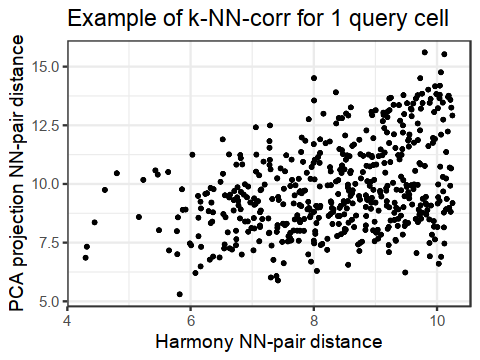

In [70]:
pdf(paste('figures/kNN-corr-1cell-pca_proj.pdf', sep = ''), height=3, width=4)
fig.size(3,4)
p = ggplot(data_1_cell, aes(x = distances_gold, y = distances_alt)) +
  geom_point_rast(size = 0.8) +
  theme_bw() + 
  xlab('Harmony NN-pair distance') + 
  ylab('PCA projection NN-pair distance') + 
  ggtitle('Example of k-NN-corr for 1 query cell')
print(p)
dev.off()
p

## Calculate full k-NN-corr results

Symphony vs. Harmony embeddings

In [71]:
gold = readRDS('../pre-built_references/pbmcs_10x_reference.rds')
colnames(gold$Z_corr) = gold$meta_data$cell_id

corr_symphony_results = NULL
for (batch in c('3pv1', '3pv2', '5p')) {
    reference = readRDS(paste0("results/", batch, "_reference.rds"))
    query = readRDS(paste0("results/", batch, "_query.rds"))
    colnames(reference$Z_corr) = reference$meta_data$cell_id
    colnames(query$Z) = query$meta_data$cell_id

    # Subset gold embedding by reference and query of interest
    idx_gold_query = which(gold$meta_data$donor == batch)
    gold_ref = gold$Z_corr[, -idx_gold_query]
    gold_query = gold$Z_corr[, idx_gold_query]
    alt_ref = reference$Z_corr
    alt_query = query$Z

    # Ensure that ordering of cells matches between gold and alt embeddings
    gold_ref = gold_ref[ , colnames(alt_ref)]
    gold_query = gold_query[, colnames(alt_query)]

    corrs = symphony::calcknncorr(gold_ref, alt_ref, gold_query, alt_query, k = 500) %>% as.data.frame()
    corrs$batch = batch
    corrs$mapping = 'Symphony'
    colnames(corrs) = c('cor', 'batch', 'mapping')
    corr_symphony_results = rbind(corr_symphony_results, corrs)
}

corr_symphony_results %>% head(5)
saveRDS(corr_symphony_results, 'results/knn_corr_symphony_500.rds')

Note: This function assumes that ordering of cells (cols) between gold and alt embeddings match

Note: This function assumes that ordering of cells (cols) between gold and alt embeddings match

Note: This function assumes that ordering of cells (cols) between gold and alt embeddings match



,cor,batch,mapping
,<dbl>,<chr>,<chr>
1,0.6372405,3pv1,Symphony
2,0.8040498,3pv1,Symphony
3,0.4140424,3pv1,Symphony
4,0.2412614,3pv1,Symphony
5,0.5358247,3pv1,Symphony


PCA_proj vs. Harmony embeddings

In [72]:
gold = readRDS('../pre-built_references/pbmcs_10x_reference.rds')
colnames(gold$Z_corr) = gold$meta_data$cell_id

corr_pca_proj_results = NULL
for (batch in c('3pv1', '3pv2', '5p')) {
    reference = readRDS(paste0("results/", batch, "_reference.rds"))
    query = readRDS(paste0("results/", batch, "_query.rds"))
    colnames(reference$Z_corr) = reference$meta_data$cell_id
    colnames(query$Z) = query$meta_data$cell_id

    # Subset gold embedding by reference and query of interest
    idx_gold_query = which(gold$meta_data$donor == batch)
    gold_ref = gold$Z_corr[, -idx_gold_query]
    gold_query = gold$Z_corr[, idx_gold_query]
    alt_ref = reference$Z_corr
    alt_query = query$Zq_pca # different from above
    colnames(alt_query) = colnames(query$Z)

    # Ensure that ordering of cells matches between gold and alt embeddings
    gold_ref = gold_ref[ , colnames(alt_ref)]
    gold_query = gold_query[, colnames(alt_query)]

    corrs = symphony::calcknncorr(gold_ref, alt_ref, gold_query, alt_query, k = 500) %>% as.data.frame()
    corrs$batch = batch
    corrs$mapping = 'PCA_proj'
    colnames(corrs) = c('cor', 'batch', 'mapping')
    corr_pca_proj_results = rbind(corr_pca_proj_results, corrs)
}

corr_pca_proj_results %>% head(5)
saveRDS(corr_pca_proj_results, 'results/knn_corr_pca_proj_500.rds')

Note: This function assumes that ordering of cells (cols) between gold and alt embeddings match

Note: This function assumes that ordering of cells (cols) between gold and alt embeddings match

Note: This function assumes that ordering of cells (cols) between gold and alt embeddings match



,cor,batch,mapping
,<dbl>,<chr>,<chr>
1,0.1880892,3pv1,PCA_proj
2,0.6978544,3pv1,PCA_proj
3,0.2604659,3pv1,PCA_proj
4,0.1238380,3pv1,PCA_proj
5,0.4281028,3pv1,PCA_proj


## Plot results

In [73]:
combined_results = rbind(corr_pca_proj_results, corr_symphony_results)
combined_results$batch_label = paste(combined_results$batch, 'query', sep = ' ')
combined_results$groups = paste(combined_results$mapping, combined_results$batch, sep = '_') 
# groups which to calculate mean for plotting
combined_results %>% head(5)

,cor,batch,mapping,batch_label,groups
,<dbl>,<chr>,<chr>,<chr>,<chr>
1,0.1880892,3pv1,PCA_proj,3pv1 query,PCA_proj_3pv1
2,0.6978544,3pv1,PCA_proj,3pv1 query,PCA_proj_3pv1
3,0.2604659,3pv1,PCA_proj,3pv1 query,PCA_proj_3pv1
4,0.1238380,3pv1,PCA_proj,3pv1 query,PCA_proj_3pv1
5,0.4281028,3pv1,PCA_proj,3pv1 query,PCA_proj_3pv1


png 
  2

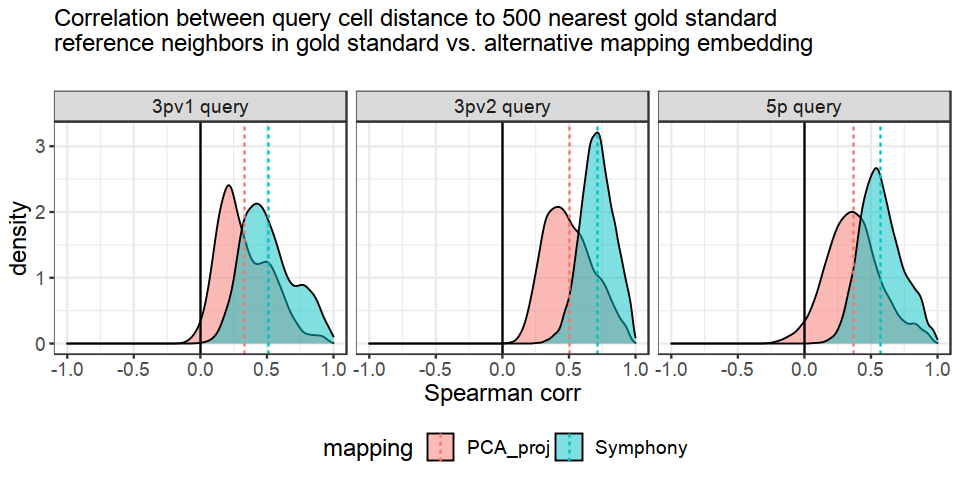

In [86]:
pdf(paste('figures/knn_corr_comparison_500.pdf', sep = ''), height = 4, width = 8)

mu = combined_results %>% group_by(groups) %>%
  mutate(mean = mean(cor))

fig.size(4, 8)
p = ggplot(combined_results, aes(cor, fill = mapping)) + 
    geom_density(alpha = 0.5, size = 0.4) +
    geom_vline(data = mu, 
               aes(xintercept = mean, color = mapping, group = groups), linetype = "dashed") +
    facet_wrap(~ batch_label) +
    theme_bw() +
    xlab('Spearman corr') + theme(legend.position = 'bottom') +
    ggtitle(paste('Correlation between query cell distance to ',
                  k, ' nearest gold standard \nreference neighbors in gold standard vs. alternative mapping embedding\n', sep = '')) +
    theme(strip.text.x = element_text(size = 11)) +
    theme(axis.text=element_text(size=11), axis.title=element_text(size=14), plot.title = element_text(size=14)) +
    theme(legend.text=element_text(size=11), legend.title=element_text(size=14)) +
    xlim(-1,1) + geom_vline(xintercept=0)

print(p)
dev.off()
p

png 
  2

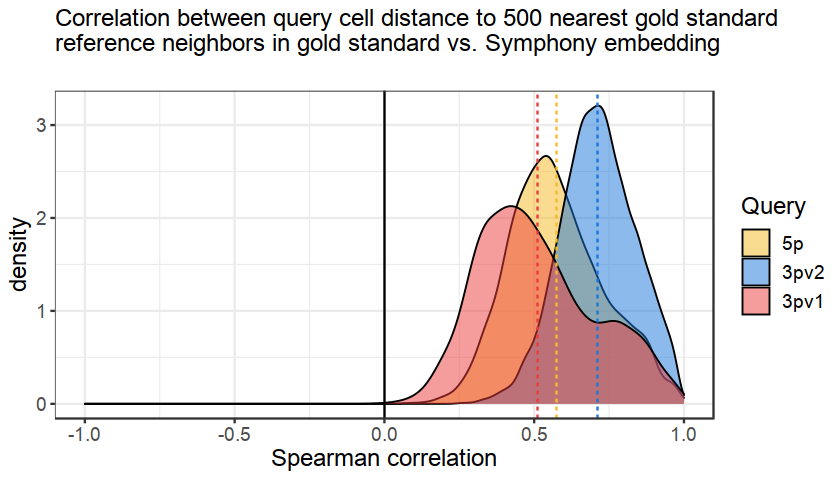

In [75]:
# Plot Symphony only
pdf(paste('figures/knn_corr_symphonyonly.pdf', sep = ''), height=4, width=7)

combined_results_symphony = combined_results[combined_results$mapping == 'Symphony', ]
combined_results_symphony$batch = factor(combined_results_symphony$batch, levels = c("5p", "3pv2", "3pv1"))

mu = combined_results_symphony %>% group_by(batch) %>% mutate(mean = mean(cor))

fig.size(4, 7)
p = ggplot(combined_results_symphony, aes(cor, fill = batch)) + 
    geom_density(alpha = 0.5, size = 0.4) +
    geom_vline(data = mu, aes(xintercept = mean, color = batch), linetype = "dashed") +
    theme_bw() +
    xlab('Spearman correlation') + theme(legend.position = 'right') +
    ggtitle(paste('Correlation between query cell distance to ',
                  k, ' nearest gold standard \nreference neighbors in gold standard vs. Symphony embedding\n', sep = '')) +
    theme(strip.text.x = element_text(size = 11)) +
    theme(axis.text=element_text(size=11), axis.title=element_text(size=14), plot.title = element_text(size=14)) +
    theme(legend.text=element_text(size=11), legend.title=element_text(size=14)) +
    xlim(-1,1) + geom_vline(xintercept=0) +
    scale_color_manual(values = c("#f5ba25", "#1c77d9", "#eb3b3b")) +
    scale_fill_manual(values = c("#f5ba25", "#1c77d9", "#eb3b3b")) + 
    guides(fill = guide_legend(title = "Query")) + guides(color = 'none')

print(p)
dev.off()
p

## Calculate k-NN-corr metrics

### Symphony

In [76]:
sum(combined_results_symphony$cor > 0) / nrow(combined_results_symphony)

[1] 0.9999028

In [77]:
sum(combined_results_symphony$cor > 0.4) / nrow(combined_results_symphony)

[1] 0.8769141

In [78]:
mean(combined_results_symphony$cor)

[1] 0.6151464

### PCA Proj

In [79]:
combined_results_pca_proj = combined_results[combined_results$mapping == 'PCA_proj', ]
sum(combined_results_pca_proj$cor > 0) / nrow(combined_results_pca_proj)

[1] 0.9852219

In [80]:
sum(combined_results_pca_proj$cor > 0.4) / nrow(combined_results_pca_proj)

[1] 0.5024549

In [81]:
mean(combined_results_pca_proj$cor)

[1] 0.4146518

### Significance test

In [82]:
wilcox.test(combined_results_symphony$cor, combined_results_pca_proj$cor, 
            paired = TRUE, alternative = "greater")


	Wilcoxon signed rank test with continuity correction

data:  combined_results_symphony$cor and combined_results_pca_proj$cor
V = 210871546, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


In [83]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lisi_1.0                biomaRt_2.46.3          RColorBrewer_1.1-2     
 [4] symphony_1.0            SeuratObject_4.0.1      Seurat_4.0.2           
 [7] ggrepel_0.9.1           ggpubr_0.4.0            ggrastr_0.2.3          
[10] pdist_1.2               reshap